In [1]:
import pandas as pd
import numpy as np
import gc
import lightgbm as lgb
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection, metrics
import pickle

print(pd.__version__) #1.1.3
print(sns.__version__) #0.11.0
print(matplotlib.__version__) # 3.3.2
print(sklearn.__version__) # 0.23.2

1.1.3
0.11.0
3.3.2
0.23.2


In [2]:
# récupération des données

data = pd.read_csv("data/train_df.csv", index_col="index")

cat_features = pickle.load(open("pickle_cat_features.pkl", "rb"))

X = data.drop(columns=['TARGET','SK_ID_CURR'])
y = data["TARGET"]

del data
gc.collect()

0

In [3]:
# rectification des noms des features pour le classifieur LGBM

def replace_name(name):
    for c in ["[","]",",","{","}",'"',":"," "]:
        if c in name :
            name = name.replace(c,"_")
    return name
            
features = list(map(replace_name, X.columns))
X.columns = features

In [4]:
# métrique LGBM personnalisée utilisant l'aire sous la courbe precision-recall (AUCPR)

def f_aucpr(y_true, probas_pred):
    
    p, r, _ = metrics.precision_recall_curve(y_true, probas_pred)
    score = metrics.auc(r,p)
    return "AUCPR", score, True

In [5]:
# séparation train et valid set

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X, y, test_size=0.2, 
                                                                      random_state=123)
del X, y
gc.collect()

60

In [6]:
# entaînement du modèle

clf = lgb.LGBMClassifier(
        n_jobs=-1,
        n_estimators=10000,
        learning_rate=0.01604238736764179,
        num_leaves=37,
        colsample_bytree=0.1626780977682063,
        subsample=0.9061817454792065,
        max_depth=5,
        reg_alpha=0.8515028010996651,
        reg_lambda=0.5421869781111216,
        min_split_gain=0.021063972265591233,
        min_child_weight=29.09287622047518,
        silent=-1,
        verbose=-1,
        random_state=123,
        categorical_feature=list(np.where(train_x.columns.isin(cat_features))[0]))

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
    eval_metric=f_aucpr, verbose= 200, early_stopping_rounds= 200)

/home/samuel/.local/lib/python3.8/site-packages/lightgbm/basic.py:1075: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  warnings.warn('{0} keyword has been found in `params` and will be ignored.\n'


Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.24393	training's AUCPR: 0.291551	valid_1's binary_logloss: 0.247155	valid_1's AUCPR: 0.261172
[400]	training's binary_logloss: 0.234301	training's AUCPR: 0.318616	valid_1's binary_logloss: 0.240522	valid_1's AUCPR: 0.274328
[600]	training's binary_logloss: 0.229067	training's AUCPR: 0.338713	valid_1's binary_logloss: 0.238016	valid_1's AUCPR: 0.281174
[800]	training's binary_logloss: 0.225288	training's AUCPR: 0.356015	valid_1's binary_logloss: 0.236705	valid_1's AUCPR: 0.28528
[1000]	training's binary_logloss: 0.222182	training's AUCPR: 0.370705	valid_1's binary_logloss: 0.235979	valid_1's AUCPR: 0.287752
[1200]	training's binary_logloss: 0.219647	training's AUCPR: 0.383465	valid_1's binary_logloss: 0.235467	valid_1's AUCPR: 0.289509
[1400]	training's binary_logloss: 0.217512	training's AUCPR: 0.394496	valid_1's binary_logloss: 0.235074	valid_1's AUCPR: 0.290985
[1600]	training's binary_lo

LGBMClassifier(categorical_feature=[0, 1, 2, 3, 9, 10, 11, 12, 13, 26, 30, 38,
                                    84, 85, 87, 88, 120],
               colsample_bytree=0.1626780977682063,
               learning_rate=0.01604238736764179, max_depth=5,
               min_child_weight=29.09287622047518,
               min_split_gain=0.021063972265591233, n_estimators=10000,
               num_leaves=37, random_state=123, reg_alpha=0.8515028010996651,
               reg_lambda=0.5421869781111216, silent=-1,
               subsample=0.9061817454792065, verbose=-1)

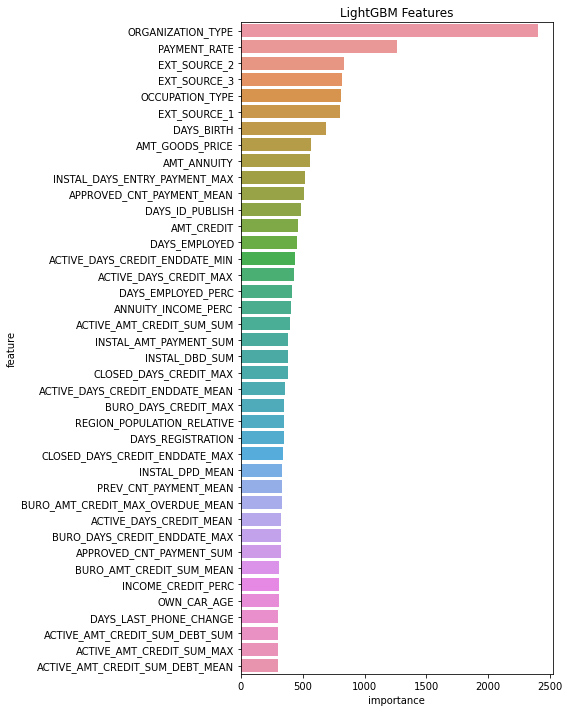

In [7]:
# features importances

feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = train_x.columns
feature_importance_df["importance"] = clf.feature_importances_
best_features_idx = feature_importance_df.sort_values(by="importance", ascending=False)[:40].index
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=feature_importance_df.iloc[best_features_idx].sort_values(by="importance", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.savefig('img/lgbm_importances02.png')

In [8]:
# enregistrement du modèle
pickle.dump(clf, open("pickle_lgbm_classifier.pkl", "wb"))